In [1]:
!git clone https://github.com/Oliverluyu/brain_tumor_img_segmentation.git
%cd brain_tumor_img_segmentation
!git checkout experiment2


Cloning into 'brain_tumor_img_segmentation'...
remote: Enumerating objects: 13168, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 13168 (delta 4), reused 14 (delta 4), pack-reused 13149
Receiving objects: 100% (13168/13168), 505.74 MiB | 32.19 MiB/s, done.
Resolving deltas: 100% (558/558), done.
Updating files: 100% (15653/15653), done.
/content/brain_tumor_img_segmentation
Branch 'experiment2' set up to track remote branch 'experiment2' from 'origin'.
Switched to a new branch 'experiment2'


Epoch 1/20, Training Loss: 0.6759, Validation Loss: 0.7580, Validation Accuracy: 72.21%
Epoch 2/20, Training Loss: 0.4804, Validation Loss: 0.5518, Validation Accuracy: 76.46%
Epoch 3/20, Training Loss: 0.3970, Validation Loss: 0.3059, Validation Accuracy: 89.56%
Epoch 4/20, Training Loss: 0.3617, Validation Loss: 0.4702, Validation Accuracy: 78.52%
Epoch 5/20, Training Loss: 0.3097, Validation Loss: 1.0675, Validation Accuracy: 69.30%
Epoch 6/20, Training Loss: 0.2695, Validation Loss: 0.3155, Validation Accuracy: 88.23%
Epoch 7/20, Training Loss: 0.2382, Validation Loss: 0.3349, Validation Accuracy: 86.17%
Epoch 8/20, Training Loss: 0.2088, Validation Loss: 1.7880, Validation Accuracy: 55.46%
Epoch 9/20, Training Loss: 0.1777, Validation Loss: 0.7461, Validation Accuracy: 79.00%
Epoch 10/20, Training Loss: 0.1499, Validation Loss: 0.8593, Validation Accuracy: 72.45%
Epoch 11/20, Training Loss: 0.1305, Validation Loss: 0.2464, Validation Accuracy: 91.50%
Epoch 12/20, Training Loss: 0.

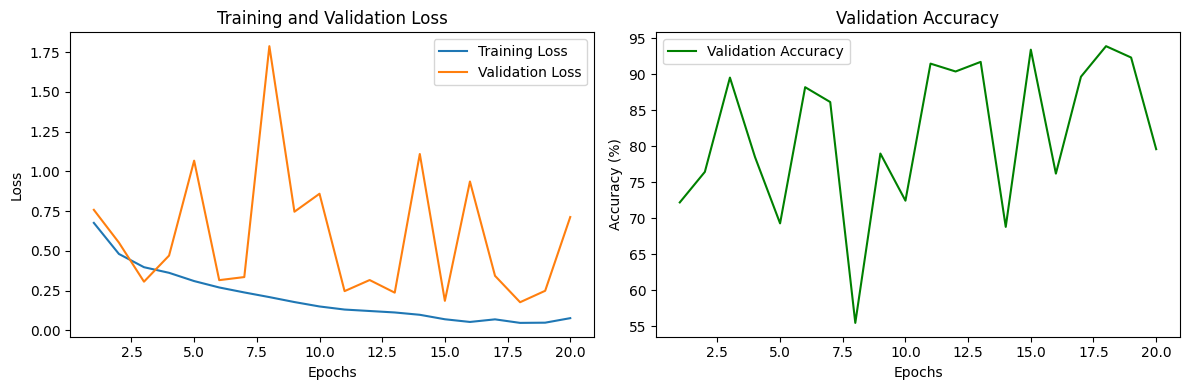



Test Accuracy: 79.41%


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt


# Define dataset directory
dataset_dir = r'datasets/classification/'
# Define batch size and image dimensions
batch_size = 32
image_size = 256

# Define data transformations for grayscale images
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((image_size, image_size)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Load sampled dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = ImageFolder(root=os.path.join(dataset_dir, 'validation'), transform=data_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define VanillaUnet model
# 4 classes for the classification task (e.g., glioma, meningioma, notumor, pituitary)
# Change the 'in_channels' to 1 for grayscale images
model = unet_2D(in_channels=1, n_classes=4, mode='classification')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store metrics
epoch_losses = []
val_epoch_losses = []
val_epoch_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs, reconstructions = model(images)
        loss = criterion(outputs, labels)
        loss += 0.5 * torch.mean((reconstructions - images)**2)  # Reconstruction loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_losses.append(val_epoch_loss)
    val_accuracy = 100 * correct / total
    val_epoch_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.plot(epochs, val_epoch_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_epoch_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'\n\nTest Accuracy: {test_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'saved_models/classification_model_20epochs.pth')

# training classification (reduced weight on reconstruction loss)

Epoch 1/20, Training Loss: 0.6373, Validation Loss: 1.0008, Validation Accuracy: 57.28%
Epoch 2/20, Training Loss: 0.4502, Validation Loss: 0.6445, Validation Accuracy: 70.51%
Epoch 3/20, Training Loss: 0.3496, Validation Loss: 0.8576, Validation Accuracy: 65.53%
Epoch 4/20, Training Loss: 0.3121, Validation Loss: 0.4901, Validation Accuracy: 84.59%
Epoch 5/20, Training Loss: 0.2565, Validation Loss: 0.4026, Validation Accuracy: 83.62%
Epoch 6/20, Training Loss: 0.2209, Validation Loss: 0.2730, Validation Accuracy: 89.68%
Epoch 7/20, Training Loss: 0.1805, Validation Loss: 0.3317, Validation Accuracy: 87.74%
Epoch 8/20, Training Loss: 0.1650, Validation Loss: 0.2017, Validation Accuracy: 92.72%
Epoch 9/20, Training Loss: 0.1481, Validation Loss: 0.6695, Validation Accuracy: 78.64%
Epoch 10/20, Training Loss: 0.1318, Validation Loss: 0.3092, Validation Accuracy: 90.41%
Epoch 11/20, Training Loss: 0.0959, Validation Loss: 0.7271, Validation Accuracy: 78.88%
Epoch 12/20, Training Loss: 0.

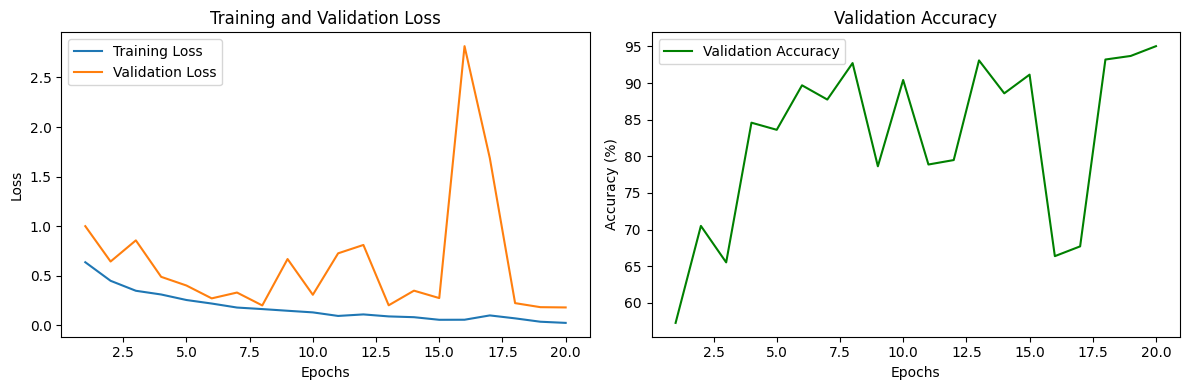



Test Accuracy: 95.58%


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt


# Define dataset directory
dataset_dir = r'datasets/classification/'
# Define batch size and image dimensions
batch_size = 32
image_size = 256

# Define data transformations for grayscale images
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((image_size, image_size)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Load sampled dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = ImageFolder(root=os.path.join(dataset_dir, 'validation'), transform=data_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define VanillaUnet model
# 4 classes for the classification task (e.g., glioma, meningioma, notumor, pituitary)
# Change the 'in_channels' to 1 for grayscale images
model = unet_2D(in_channels=1, n_classes=4, mode='classification')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store metrics
epoch_losses = []
val_epoch_losses = []
val_epoch_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs, reconstructions = model(images)
        loss = criterion(outputs, labels)
        loss += 0.1 * torch.mean((reconstructions - images)**2)  # Reconstruction loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_losses.append(val_epoch_loss)
    val_accuracy = 100 * correct / total
    val_epoch_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.plot(epochs, val_epoch_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_epoch_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'\n\nTest Accuracy: {test_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'saved_models/classification_model_20epochs.pth')

Epoch 1/20, Training Loss: 0.6305, Validation Loss: 0.6050, Validation Accuracy: 75.85%
Epoch 2/20, Training Loss: 0.4111, Validation Loss: 0.4685, Validation Accuracy: 83.25%
Epoch 3/20, Training Loss: 0.3209, Validation Loss: 0.6522, Validation Accuracy: 73.42%
Epoch 4/20, Training Loss: 0.2684, Validation Loss: 0.6583, Validation Accuracy: 77.31%
Epoch 5/20, Training Loss: 0.2563, Validation Loss: 0.4712, Validation Accuracy: 82.16%
Epoch 6/20, Training Loss: 0.2175, Validation Loss: 0.4941, Validation Accuracy: 85.68%
Epoch 7/20, Training Loss: 0.1733, Validation Loss: 0.2339, Validation Accuracy: 91.63%
Epoch 8/20, Training Loss: 0.1581, Validation Loss: 0.7543, Validation Accuracy: 77.67%
Epoch 9/20, Training Loss: 0.1395, Validation Loss: 0.2758, Validation Accuracy: 90.66%
Epoch 10/20, Training Loss: 0.1200, Validation Loss: 0.4975, Validation Accuracy: 82.04%
Epoch 11/20, Training Loss: 0.1134, Validation Loss: 0.3147, Validation Accuracy: 91.63%
Epoch 12/20, Training Loss: 0.

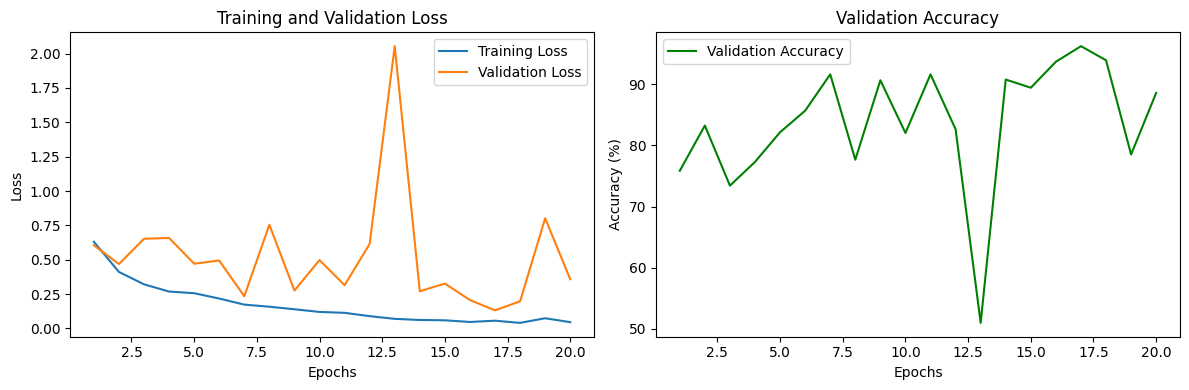



Test Accuracy: 87.95%


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt


# Define dataset directory
dataset_dir = r'datasets/classification/'
# Define batch size and image dimensions
batch_size = 32
image_size = 256

# Define data transformations for grayscale images
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.Resize((image_size, image_size)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Load sampled dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = ImageFolder(root=os.path.join(dataset_dir, 'validation'), transform=data_transforms)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define VanillaUnet model
# 4 classes for the classification task (e.g., glioma, meningioma, notumor, pituitary)
# Change the 'in_channels' to 1 for grayscale images
model = unet_2D(in_channels=1, n_classes=4, mode='classification')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to store metrics
epoch_losses = []
val_epoch_losses = []
val_epoch_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs, reconstructions = model(images)
        loss = criterion(outputs, labels)
        loss += 0.05 * torch.mean((reconstructions - images)**2)  # Reconstruction loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_losses.append(epoch_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_losses.append(val_epoch_loss)
    val_accuracy = 100 * correct / total
    val_epoch_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plotting the metrics
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_losses, label='Training Loss')
plt.plot(epochs, val_epoch_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_epoch_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Test the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'\n\nTest Accuracy: {test_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'saved_models/classification_model_20epochs_0p05.pth')